In [248]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [221]:
train_wOrdinal = pd.read_csv('~/Documents/AmesHousingML/clean_data_ordinal.csv') 
train_originalCleaned = pd.read_csv('~/Documents/AmesHousingML/clean_data_original.csv') 
train_wOnlyDummies = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified.csv') 
train_wOnlyDummiesNoDrop = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified_noDrop.csv') 

In [222]:
print(train_originalCleaned.shape)
print(train_wOnlyDummies.shape)
print(train_wOrdinal.shape)

(2576, 86)
(2576, 266)
(2576, 86)


## Finding & Dealing with Outliers

In [223]:
outlier_threshold = 3

In [224]:
Q1 = train_wOrdinal['SalePrice'].quantile(.25)
Q3 = train_wOrdinal['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [225]:
before_outlier_total = train_wOrdinal.count()[1]
train_wOrdinal.drop(train_wOrdinal[train_wOrdinal['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOrdinal.count()[1]

In [226]:
before_outlier_total - post_outlier_total

23

In [227]:
Q1 = train_originalCleaned['SalePrice'].quantile(.25)
Q3 = train_originalCleaned['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [228]:
before_outlier_total = train_originalCleaned.count()[1]
train_originalCleaned.drop(train_originalCleaned[train_originalCleaned['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_originalCleaned.count()[1]

In [229]:
before_outlier_total - post_outlier_total

23

In [230]:
Q1 = train_wOnlyDummies['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummies['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [231]:
before_outlier_total = train_wOnlyDummies.count()[1]
train_wOnlyDummies.drop(train_wOnlyDummies[train_wOnlyDummies['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummies.count()[1]

In [232]:
before_outlier_total - post_outlier_total

23

In [233]:
Q1 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [234]:
before_outlier_total = train_wOnlyDummiesNoDrop.count()[1]
train_wOnlyDummiesNoDrop.drop(train_wOnlyDummiesNoDrop[train_wOnlyDummiesNoDrop['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummiesNoDrop.count()[1]

In [235]:
before_outlier_total - post_outlier_total

23

In [245]:
# masterScores = pd.DataFrame(columns = ['Model', 'r2_score'])

In [236]:
ourFrames = [train_wOrdinal, train_wOnlyDummies, train_wOnlyDummiesNoDrop]

In [237]:
for frame in ourFrames:
    frame = frame.drop('PID', axis=1)

In [254]:
masterScores = pd.DataFrame(columns = ['Model', 'r2_5kf_mean', 'rmse_5kf_mean'])

In [252]:
for frame in ourFrames:
    #the features will be X (independent variables)
    X = frame.drop('SalePrice', axis=1)
    X_array = X.values
    #the target (dependent variable) will be y
    y = frame['SalePrice']
    y_array = y.values

    #Split your training and testing sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed

    # Train the model on the training set
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    rf_y_pred = rf_model.predict(X_test)

    # Evaluate the Random Forest model
    rf_r2 = r2_score(y_test, rf_y_pred)
    print(f'R-squared on the test set: {rf_r2}')

    rf_mse = mean_squared_error(y_test, rf_y_pred)
    print(f'Mean Squared Error on the test set: {rf_mse}')

    # Root Mean Squared Error (RMSE) on the test set
    rf_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
    print("Root Mean Squared Error (RMSE) on the test set:", rf_rmse)

    # Display feature importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    print('\nFeature Importances:')
    print(feature_importances)
    # feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    # feat_importances.nlargest(20).plot(kind='barh')
    
    # Create a KFold object
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
    # You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.
    # Define the custom scoring function for RMSE
    def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
    # Define the scoring function using neg_mean_squared_error
    scorer = make_scorer(rmse_scorer)
    # Use cross_val_score with the defined scorer
    rmse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring=scorer)

    

    # Display the cross-validation scores
    print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
    print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

    # Print the mean and standard deviation of the scores
    print(f"Mean R^2: {cv_scores.mean()}", '\n')
    print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
    print(f"Mean RMSE: {rmse_scores.mean()}")
    
    print('\n')
    print('\n')
    print('\n')
    
    

R-squared on the test set: 0.9071261258067371
Mean Squared Error on the test set: 447554387.08315355
Root Mean Squared Error (RMSE) on the test set: 21155.481253877293

Feature Importances:
            Feature  Importance
81    HighQualFinSF    0.300430
18      OverallQual    0.228609
76     TotalHouseSF    0.217301
20        YearBuilt    0.048260
79  YearAndRemodAvg    0.013870
..              ...         ...
7             Alley    0.000097
69        3SsnPorch    0.000093
46     LowQualFinSF    0.000006
10        Utilities    0.000004
6            Street    0.000002

[85 rows x 2 columns]
Cross-Validation Scores Rsquared: [0.90436372 0.89616602 0.9219125  0.90709789 0.87398736] 

Cross-Validation Scores RMSE: [21467.7964974  22268.40726794 18648.40892012 20365.62376334
 22397.75698669] 

Mean R^2: 0.9007054964836751 

Standard Deviation R^2: 0.015738155524322794 

Mean RMSE: 21029.598687098645






R-squared on the test set: 0.902995393966292
Mean Squared Error on the test set: 46746

In [239]:

train_wOrdinal.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,909176150,856,126000,30,5,60.0,7890,1,1,3,3,0,0,0,19,2,2,0,2,6,6,1939,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,3,238.0,1,0.0,618.0,856.0,1,3,1,3,856,0,0,1.0,0.0,1,0,2,1,3,4,6,1,5,5,1939.0,1,2.0,399.0,4,4,2,0,0,0,0,166,1,3,2010,9,4,1712.0,2.0,166,1944.5,-6178.0,1712.0,21.698352,0.760456,2.103929
1,905476230,1049,139500,120,5,42.0,4235,1,1,3,3,0,4,0,7,2,2,4,2,5,5,1984,1984,1,0,6,6,1,149.0,4,3,1,5,4,3,3,552.0,2,393.0,104.0,1049.0,1,3,1,3,1049,0,0,1.0,0.0,2,0,2,1,4,5,6,0,1,1,1984.0,3,1.0,266.0,4,4,2,0,105,0,0,0,1,2,2009,9,4,2098.0,3.0,105,1984.0,-2137.0,2098.0,49.539551,0.991736,2.479339
2,911128020,1001,124900,30,1,60.0,6060,1,1,3,3,0,4,0,10,2,2,0,2,5,9,1930,2007,3,0,8,8,2,0.0,4,3,0,4,4,2,2,737.0,1,0.0,100.0,837.0,1,5,1,3,1001,0,0,0.0,0.0,1,0,2,1,4,5,6,0,1,5,1930.0,1,1.0,216.0,4,2,0,154,0,42,86,0,1,11,2007,9,4,1838.0,1.0,282,1968.5,-4222.0,1838.0,30.330033,0.990099,4.653465
3,535377150,1039,114000,70,5,80.0,8146,1,1,3,3,0,0,0,18,2,2,0,5,4,8,1900,2003,1,0,8,8,2,0.0,4,4,0,3,4,2,1,0.0,1,0.0,405.0,405.0,1,4,1,3,717,322,0,0.0,0.0,1,0,2,1,3,6,6,0,1,5,1940.0,1,1.0,281.0,4,4,0,0,0,168,0,111,1,5,2009,9,4,1444.0,1.0,279,1951.5,-6702.0,1444.0,17.726492,0.982077,3.424994
4,534177230,1665,227000,60,5,70.0,8400,1,1,3,3,0,4,0,15,2,2,0,5,8,6,2001,2001,1,0,12,13,2,0.0,4,3,2,5,4,2,3,643.0,1,0.0,167.0,810.0,1,5,1,3,810,855,0,1.0,0.0,2,1,3,1,4,6,6,0,1,1,2001.0,3,2.0,528.0,4,4,2,0,45,0,0,0,1,11,2009,9,4,2475.0,3.5,45,2001.0,-5925.0,2475.0,29.464286,0.833333,0.535714


In [259]:
#name the model for our score tracker
model_name = 'randomForest'
train_wOrdinal = train_wOrdinal.drop('PID', axis=1)


#the features will be X (independent variables)
X = train_wOrdinal.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_wOrdinal['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_r2 = r2_score(y_test, rf_y_pred)
# print(f'R-squared on the test set: {rf_r2}')

rf_mse = mean_squared_error(y_test, rf_y_pred)
# print(f'Mean Squared Error on the test set: {rf_mse}')

# Root Mean Squared Error (RMSE) on the test set
rf_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
# print("Root Mean Squared Error (RMSE) on the test set:", rf_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)
# feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='barh')

# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)


Feature Importances:
            Feature  Importance
80    HighQualFinSF    0.286348
75     TotalHouseSF    0.231843
17      OverallQual    0.228551
19        YearBuilt    0.048250
78  YearAndRemodAvg    0.014079
..              ...         ...
68        3SsnPorch    0.000085
39          Heating    0.000042
45     LowQualFinSF    0.000008
9         Utilities    0.000004
5            Street    0.000001

[84 rows x 2 columns]
Cross-Validation Scores Rsquared: [0.90471939 0.89691385 0.91986302 0.90581684 0.87268399] 

Cross-Validation Scores RMSE: [21427.83985726 22188.07089472 18891.54619576 20505.55579038
 22513.29133582] 

Mean R^2: 0.8999994192149027 

Standard Deviation R^2: 0.015532782416819753 

Mean RMSE: 21105.260814788413


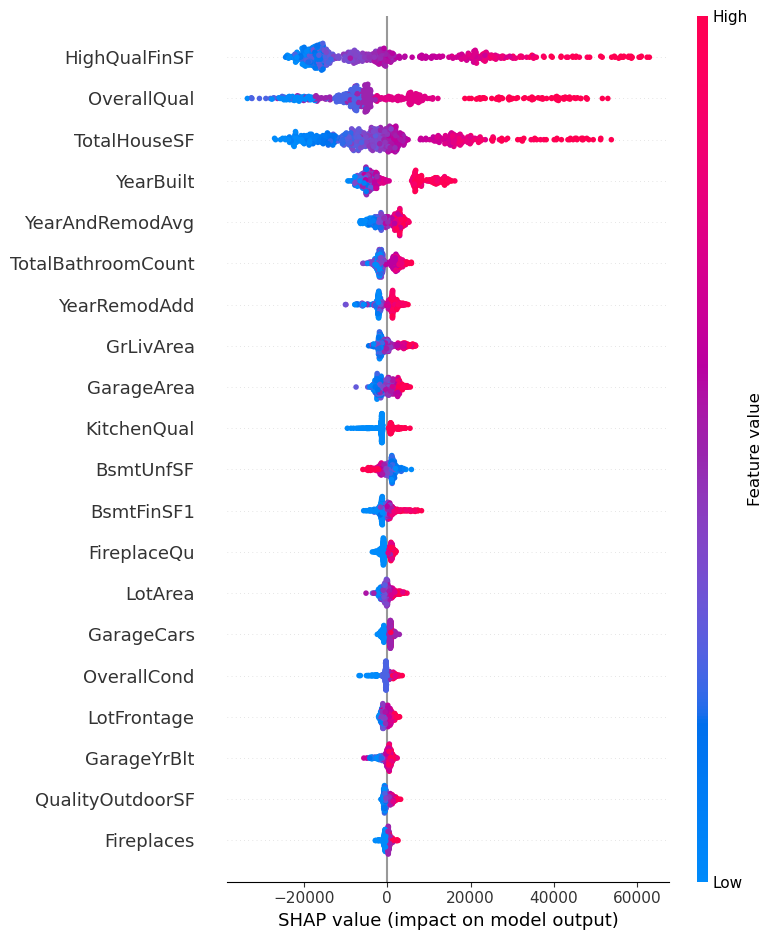

In [267]:
import shap

# Use the SHAP explainer
explainer = shap.Explainer(rf_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test)

In [264]:
masterScores

,Model,r2_5kf_mean,rmse_5kf_mean
1,randomForest,0.899999,21105.260815


In [266]:
output_file = 'masterScores_randomForest.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_randomForest.csv' in the same working directory.


In [241]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    
    model = RandomForestRegressor(n_estimators = n_estimators, 
                                  max_depth = max_depth, 
                                  min_samples_split = min_samples_split, 
                                  min_samples_leaf = min_samples_leaf)
    
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1).mean()
    
    return score

In [242]:
# study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed=42))

[I 2024-01-26 13:22:22,370] A new study created in memory with name: no-name-a10d6656-d9fb-445a-8aad-fce0db5d0f21


In [243]:
#study.optimize(objective, n_trials = 200)

In [244]:
# study.best_params

ValueError: No trials are completed yet.

In [ ]:
# best_params = study.best_params

In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# optuna.visualization.plot_slice(study,params=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'])

In [ ]:
# optuna.visualization.plot_param_importances(study)

In [ ]:
# best_n_estimators = best_params['n_estimators']
# best_max_depth = best_params['max_depth']
# best_min_samples_split = best_params['min_samples_split']
# best_min_samples_leaf = best_params['min_samples_leaf']



In [ ]:
# best_model = RandomForestRegressor(n_estimators=best_n_estimators,
#                                    max_depth=best_max_depth,
#                                    min_samples_split=best_min_samples_split,
#                                    min_samples_leaf=best_min_samples_leaf)

In [ ]:
# best_model.fit(X_train,y_train)

In [ ]:
# y_pred = best_model.predict(X_test)

In [ ]:
# mean_squared_error(y_test, y_pred, squared = False)

In [ ]:
# r2_score(y_test, y_pred)